In [1]:
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, roc_auc_score, auc
from sklearn.preprocessing import minmax_scale
from skimage.feature import hog
from skimage import io
from skimage.filters import threshold_sauvola
from skimage.color import rgb2gray
from skimage.transform import resize
from scipy import ndimage
from skimage import measure
import matplotlib.patches as mpatches
from imblearn.over_sampling import SVMSMOTE
plt.rcParams['figure.figsize'] = (15, 6)

# <center>521160P Johdatus Tekoälyyn<br><br>Harjoitus #3<br><br>Luokittelu<br></center>

Tässä harjoituksessa validoidaan luokittelijoille optimaaliset hyperparametrien arvot ja vertaillaan balansoidun ja epäbalansoidun opetusdatan vaikutusta luokittelijan suorituskykyyn. Harjoitus tulee palauttaa **Katso harjoitukseen liittyvät palautuksen deadline moodlesta** (tämän harjoituksen palautusohjeet ovat hivenen erilaiset aiempien harjoituksien palautusohjeisiin verrattuna). Harjoituksesta on mahdollisuus saada 4 pistettä (2.0p + 2.0p).

Jos kohtaat ongelmia harjoitusta tehdessäsi tai sinulla on kysyttävää harjoitukseen liittyen ole yhteydessä **Moodlesta** löytyvän **ohjelmointiharjoitus 3** foorumin kautta.

**Täytä aluksi ryhmäsi jäsenten tiedot (nimi ja opiskelijanumero)**

# Ryhmän jäsenten tiedot:

* **Jäsen 1 :** ``

# Tehtävä 1. Luokittelijoiden validoiminen ja testaaminen

Tässä tehtävässä opetetaan kolme erilaista luokittelijaa MNIST-datan luokitteluun, validoidaan luokittelijat ja arvioidaan luokittelijoiden suorituskykyä. MNIST-data sisältää käsinkirjoitetut numerot 0:sta 9:sään. Jokaista luokkaa kohden datassa on 7000 näytettä eli kyseessä on balansoitu data. Yhteensä MNIST-datassa on 70 000 näytettä, jotka on kerätty Yhdysvaltojen väestölaskentaviraston työntekijöiltä ja toisen asteen opiskelijoilta. Datanäytteet on skaalattu 20x20 pikselin kokoisiksi harmaasävykuviksi ja lopuksi keskitetty 28x28 pikselin ruudukolle. Tällä datalla opetettujen yksinkertaisten luokittelijoiden luokittelutarkkuudet vaihtelevat 80 % ja 99 % välillä. Kuvassa 1 on esimerkkinäytteitä MNIST-datan kymmenestä luokasta.

<br>
<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='kuvat\mnist.png' width='650' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Kuva 1. Esimerkkikuvia MNIST-datan kymmenestä luokasta.</span>
</div>
<br>

Datan näytteitä ei syötetä suoraan luokittelualgoritmeille, vaan kuvien esikäsittelyllä saavutetaan parempi lopputulos. Datan esikäsittelymenetelmäksi valitaan HOG (engl. histogram of oriented gradients). 

HOG-menetelmä laskee kuvalle piirrevektorin, joka on lähes identtinen samalle kuvalle eri kontrastin arvoilla. Aluksi menetelmässä syötekuva jaetaan lohkoihin. Jokaiselle lohkon pikselille lasketaan gradientti, joka kertoo kuvan tummenemisen suunnan ja suuruuden. Sijoittamalla lohkon gradientit histogrammiin, saadaan lohkon HOG-piirteet. Kuvassa 2 on laskettu MNIST-datanäytteelle HOG-piirteet ja lopuksi visualisoitu ne lähtökuvassa. Syötekuva on jaettu 16 lohkoon ja gradientit on kynnystetty 40 asteen välein.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='kuvat\hog.png' width='750' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Kuva 2. HOG-piirteet MNIST-datanäytteelle.</span>
</div>
<br>

Käytetään tässä tehtävässä alkuperäisten 70 000 näytteen sijaan 10 000 näytettä. Jaetaan lasketut HOG-piirteet scikit-learn kirjaston [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) funktiolla opetus-, validointi- ja testidataan 80:10:10 jakosuhteella. Jaon jälkeen opetusdatassa on 8000 näytettä, validointidatassa 1000 näytettä ja testidatassa 1000 näytettä.

In [4]:
# Ladataan MNIST-data. Data sisältää 784 muuttujaa (28x28 harmaasävykuva) ja luokat datan luokkatiedot
data, luokat = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
data, luokat = np.asarray(data, 'int16'), np.asarray(luokat, 'int')
data, luokat = data[:10000], luokat[:10000]

# Lasketaan kuville HOG-piirteet
piirteet = []
for näyte in data:
    piirteet.append(hog(näyte.reshape((28, 28)), orientations=9, pixels_per_cell=(7, 7), cells_per_block=(1, 1), block_norm="L2-Hys", visualize=False))

# Jaetaan piirteet opetusdataan, validointidataan ja testidataan kahdessa vaiheessa
data_opetus, data_tmp, luokat_opetus, luokat_tmp = train_test_split(piirteet, luokat, test_size=(1/5), random_state=0)
data_testi, data_validointi, luokat_testi, luokat_validointi = train_test_split(data_tmp, luokat_tmp, test_size=(1/2), random_state=0)

# Tulostetaan opetusdatan, validointidatan ja testidatan näytteiden lukumäärät
print('Opetusdatassa on {} näytettä'.format(luokat_opetus.shape[0]))
print('Validointidatassa on {} näytettä'.format(luokat_validointi.shape[0]))
print('Testidatassa on {} näytettä'.format(luokat_testi.shape[0]))

Opetusdatassa on 8000 näytettä
Validointidatassa on 1000 näytettä
Testidatassa on 1000 näytettä


Seuraavaksi käytetään validointidataa etsimään k-lähimmän naapurin luokittelijalle (engl. k-nearest neighbors, k-NN), lineaariselle tukivektorikoneelle (engl. linear support vector machines, linear SVM) ja logistiselle regressiolle optimaaliset hyperparametrien arvot.

## k-lähimmän naapurin luokittelijan validoiminen

Aloitetaan validoiminen [k-lähimmän naapurin luokittelijan](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) naapureiden lukumäärästä $k$. Käydään läpi silmukassa $k$:n arvot 1-33 neljän askeleen välein. Tämän jälkeen piirretään kuvaajaan $k$:n arvon vaikutus luokittelutarkkuuteen ja valitaan kuvaajasta paras $k$:n arvo.

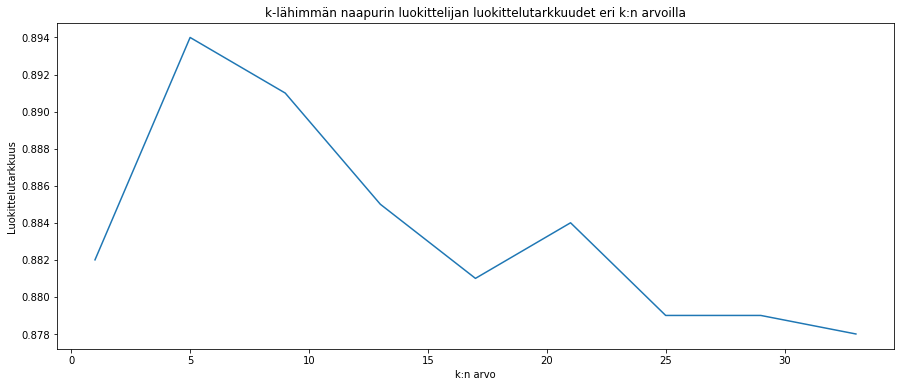

Paras k:n arvo k-lähimmän naapurin luokittelijalle: 5


In [5]:
# Suoritetaan k-lähimmän naapurin luokittelijan validoiminen
# Käydään läpi silmukassa k:n arvot 1-33 neljän askeleen välein
luokittelutarkkuudet_knn = []
k_arvot = range(1,34,4)
for k in k_arvot:
    luokittelija_knn = KNeighborsClassifier(n_neighbors=k).fit(data_opetus, luokat_opetus)
    luokittelutarkkuudet_knn.append(accuracy_score(luokat_validointi, luokittelija_knn.predict(data_validointi)))
    
# Piirretään kuvaajaan k:n arvon vaikutus luokittelutarkkuuteen
plt.plot(k_arvot, luokittelutarkkuudet_knn)
plt.title('k-lähimmän naapurin luokittelijan luokittelutarkkuudet eri k:n arvoilla')
plt.xlabel('k:n arvo')
plt.ylabel('Luokittelutarkkuus')
plt.show()

# Valitaan lopuksi kuvaajasta paras k:n arvo
maksimi_indeksi_knn = np.argmax(luokittelutarkkuudet_knn)
print('Paras k:n arvo k-lähimmän naapurin luokittelijalle: {}'.format(k_arvot[maksimi_indeksi_knn]))

## Lineaarisen tukivektorikoneen validoiminen

Tukivektorikone pyrkii sovittamaan luokkien välille sellaisen päätöstason, että luokkien välinen marginaali on mahdollisimman iso. Lineaariselle tukivektorikoneelle tärkein hyperparametrin arvo on $C$. Sen suuruus kertoo, kuinka paljon vältellään luokittelemasta väärin opetusdatan näytteitä. Suurilla $C$:n arvoilla voidaan painottaa pienempi marginaalisten päätöstasojen valintaa, mikäli niillä päästään parempaan opetusdatan luokittelutulokseen. Pienillä $C$:n arvoilla puolestaan painotetaan suuremman marginaalin päätöstasojen valintaa opetusdatan luokittelutuloksen kustannuksella.

Validoidaan seuraavaksi [lineaarisen tukivektorikoneen](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) hyperparametrin arvoa $C$. Käydään läpi silmukassa $C$:n arvot $10^{n}$, missä $n$ on -5, -4, ..., 14, 15. Tämän jälkeen piirretään kuvaajaan $C$:n eksponentin arvon vaikutus luokittelutarkkuuteen ja valitaan kuvaajasta paras $C$:n arvo.

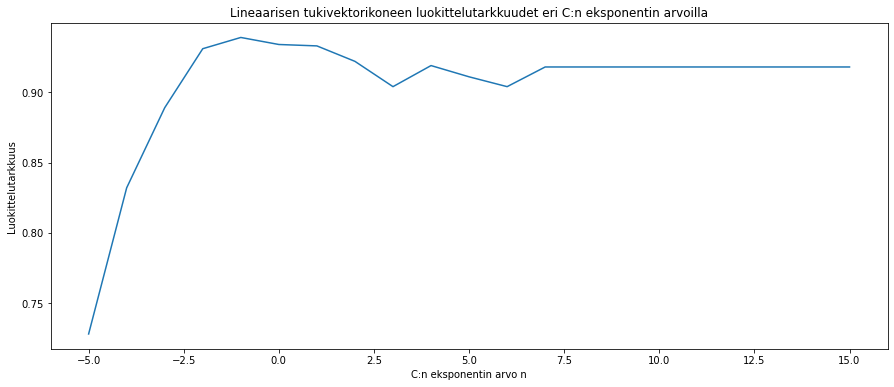

Paras C:n arvo lineaariselle tukivektorikoneelle: 10^(-1.0)


In [6]:
# Suoritetaan lineaarisen tukivektorikoneen validoiminen
# Käydään läpi silmukassa C:n eksponentin arvot -5, -4, ..., 14, 15
luokittelutarkkuudet_lineaarinen_svm = []
n1 = np.array(range(-5,16),dtype=float)
C1_arvot = 10**n1
for C1 in C1_arvot:
    luokittelija_lineaarinen_svm = LinearSVC(C=C1, random_state=0).fit(data_opetus, luokat_opetus)
    luokittelutarkkuudet_lineaarinen_svm.append(accuracy_score(luokat_validointi, luokittelija_lineaarinen_svm.predict(data_validointi)))
    
# Piirretään kuvaajaan C:n eksponentin arvon vaikutus luokittelutarkkuuteen
plt.plot(n1, luokittelutarkkuudet_lineaarinen_svm)
plt.title('Lineaarisen tukivektorikoneen luokittelutarkkuudet eri C:n eksponentin arvoilla')
plt.xlabel('C:n eksponentin arvo n')
plt.ylabel('Luokittelutarkkuus')
plt.show()

# Valitaan lopuksi kuvaajasta paras C:n arvo
maksimi_indeksi_lineaarinen_svm = np.argmax(luokittelutarkkuudet_lineaarinen_svm)
print('Paras C:n arvo lineaariselle tukivektorikoneelle: 10^({})'.format(n1[maksimi_indeksi_lineaarinen_svm]))

## Logistisen regression validoiminen

Validoidaan vielä [logistisen regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) hyperparametrin arvoa $C$. Sillä säädetään luokittelijan regularisoinnin voimakkuutta. Käydään läpi silmukassa $C$:n arvot $10^{n}$, missä $n$ on -5, -4, ..., 14, 15. Tämän jälkeen piirretään kuvaajaan $C$:n eksponentin arvon vaikutus luokittelutarkkuuteen ja valitaan kuvaajasta paras $C$:n arvo.

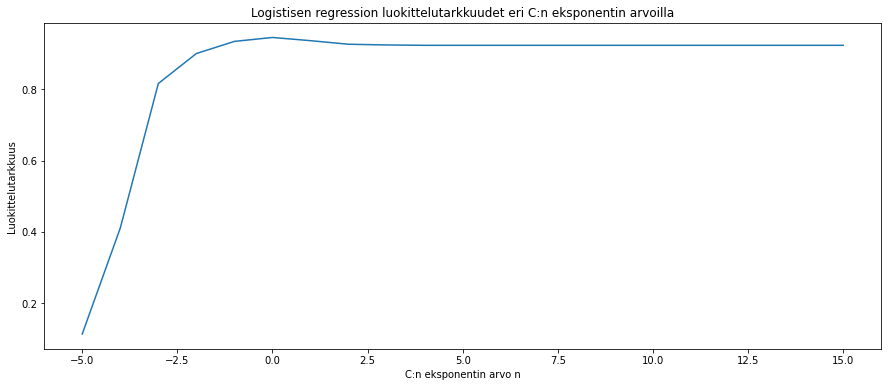

Paras C:n arvo logistiselle regressiolle: 10^(0.0)


In [7]:
# Suoritetaan logistisen regression validoiminen
# Käydään läpi silmukassa C:n eksponentin arvot -5, -4, ..., 14, 15
luokittelutarkkuudet_logistinen_regressio = []
n2 = np.array(range(-5,16),dtype=float)
C2_arvot = 10**n2
for C2 in C2_arvot:
    luokittelija_logistinen_regressio = LogisticRegression(C=C2, solver='sag', random_state=0).fit(data_opetus, luokat_opetus)
    luokittelutarkkuudet_logistinen_regressio.append(accuracy_score(luokat_validointi, luokittelija_logistinen_regressio.predict(data_validointi)))
    
# Piirretään kuvaajaan C:n eksponentin arvon vaikutus luokittelutarkkuuteen
plt.plot(n2, luokittelutarkkuudet_logistinen_regressio)
plt.title('Logistisen regression luokittelutarkkuudet eri C:n eksponentin arvoilla')
plt.xlabel('C:n eksponentin arvo n')
plt.ylabel('Luokittelutarkkuus')
plt.show()

# Valitaan lopuksi kuvaajasta paras C:n arvo
maksimi_indeksi_logistinen_regressio = np.argmax(luokittelutarkkuudet_logistinen_regressio)
print('Paras C:n arvo logistiselle regressiolle: 10^({})'.format(n2[maksimi_indeksi_logistinen_regressio]))

Kun luokittelijoiden parhaat hyperparametrien arvot on selvitetty, poimi ne ja opeta niitä käyttämällä lopulliset luokittelijat. Sinun tulee siis antaa paras $k$:n arvo k-lähimmän naapurin luokittelijalle, paras $C$:n eksponentti $n_1$ lineaariselle tukivektorikoneelle ja paras $C$:n eksponentti $n_2$ logistiselle regressiolle.

In [8]:
# Opetetaan luokittelijat parhailla hyperparametrien arvoilla
#-------- TÄHÄN SINUN KOODI --------
k = k_arvot[maksimi_indeksi_knn]
n1 = -1.0
n2 = 0.0
#-----------------------------------

luokittelija_knn_validoitu = KNeighborsClassifier(n_neighbors=k).fit(data_opetus, luokat_opetus)
luokittelija_lineaarinen_svm_validoitu = LinearSVC(C=10**(n1), random_state=0).fit(data_opetus, luokat_opetus)
luokittelija_logistinen_regressio_validoitu = LogisticRegression(C=10**(n2), solver='sag', random_state=0).fit(data_opetus, luokat_opetus)

Arvioidaan seuraavaksi luokittelijoiden suorituskykyä sekaannusmatriisien ja luokittelutarkkuuksien perusteella.

Luokittelutarkkuus k-lähimmän naapurin luokittelijalle: 89.5 %
Luokittelutarkkuus lineaariselle tukivektorikoneelle: 94.0 %
Luokittelutarkkuus logistiselle regressiolle: 94.6 %


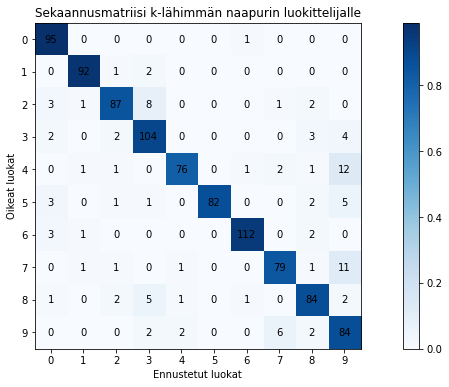

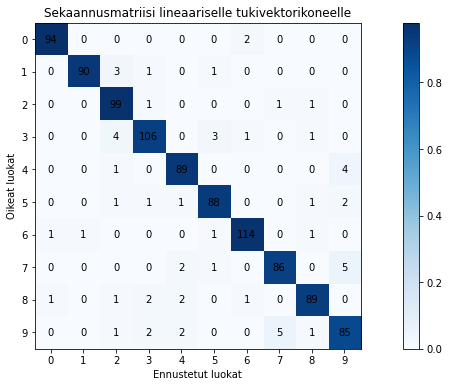

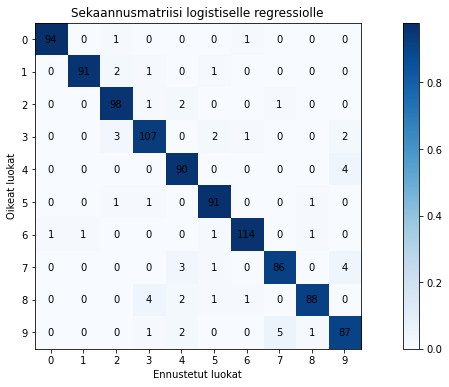

In [9]:
def tulosta_sekaannusmatriisi(sekaannusmatriisi, otsikko):
    """
    Tämä funktio tulostaa sekaannusmatriisin graafisesti
    """
    normalisoidut_arvot = []
    for rivi in sekaannusmatriisi:
        summa = 0
        arvot = []
        summa = sum(rivi, 0)
        for arvo in rivi:
            arvot.append(float(arvo)/float(summa))
        normalisoidut_arvot.append(arvot)
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    värit = ax.imshow(np.array(normalisoidut_arvot), cmap=plt.cm.Blues, interpolation='nearest')
    leveys, korkeus = sekaannusmatriisi.shape
    for i in range(leveys):
        for j in range(korkeus):
            ax.annotate(str(sekaannusmatriisi[i][j]), xy=(j, i), horizontalalignment='center', verticalalignment='center')
    fig.colorbar(värit)
    luokat = '0123456789'
    plt.xticks(range(leveys), luokat[:leveys])
    plt.yticks(range(korkeus), luokat[:korkeus])
    plt.title(otsikko)
    plt.xlabel("Ennustetut luokat")
    plt.ylabel("Oikeat luokat")
    
# Ennustetaan luokat validoidulla k-lähimmän naapurin luokittelijalla, sijoitetaan ennustetut luokat sekaannusmatriisiin ja lasketaan luokittelutarkkuus
luokat_ennustettu_knn = luokittelija_knn_validoitu.predict(data_testi)
tulosta_sekaannusmatriisi(confusion_matrix(luokat_testi, luokat_ennustettu_knn), 'Sekaannusmatriisi k-lähimmän naapurin luokittelijalle')
print('Luokittelutarkkuus k-lähimmän naapurin luokittelijalle: {} %'.format(round(100*accuracy_score(luokat_testi, luokat_ennustettu_knn),3)))

# Ennustetaan luokat validoidulla lineaarisella tukovektorikoneella, sijoitetaan ennustetut luokat sekaannusmatriisiin ja lasketaan luokittelutarkkuus
luokat_ennustettu_lineaarinen_svm = luokittelija_lineaarinen_svm_validoitu.predict(data_testi)
tulosta_sekaannusmatriisi(confusion_matrix(luokat_testi, luokat_ennustettu_lineaarinen_svm), 'Sekaannusmatriisi lineaariselle tukivektorikoneelle')
print('Luokittelutarkkuus lineaariselle tukivektorikoneelle: {} %'.format(round(100*accuracy_score(luokat_testi, luokat_ennustettu_lineaarinen_svm),3)))

# Ennustetaan luokat validoidulla logistisella regressiolla, sijoitetaan ennustetut luokat sekaannusmatriisiin ja lasketaan luokittelutarkkuus
luokat_ennustettu_logistinen_regressio = luokittelija_logistinen_regressio_validoitu.predict(data_testi)
tulosta_sekaannusmatriisi(confusion_matrix(luokat_testi, luokat_ennustettu_logistinen_regressio), 'Sekaannusmatriisi logistiselle regressiolle')
print('Luokittelutarkkuus logistiselle regressiolle: {} %'.format(round(100*accuracy_score(luokat_testi, luokat_ennustettu_logistinen_regressio),3)))
plt.show()

**Mikä validoiduista luokittelijoista on paras luokittelutarkkuuden perusteella? Tulkitsemalla sekaannusmatriisia, mihin luokkaan/luokkiin k-lähimmän naapurin luokittelija sekoittaa useimmin käsinkirjoitetun numeron 4?**

`Luokittelutarkkuuden perusteella logistinen regressio on paras luokittelija 94.6%, verrattuna k-lähimmän naapurin luokittelija 89.5% ja lineaariselle tukivektorikone 94.0%. k-lähimmän naapurin luokittelija sekoittaa useimmin käsinkirjoitetun numeron 4 luokkaan 9`

Testataan vielä kolmelle testikuvalle, kuinka hyvin validoitu k-lähimmän naapurin luokittelija suoriutuu luokittelutehtävästä. Käsinkirjoitetut numerot segmentoidaan kuvasta Sauvolan binärisointi-menetelmällä, jonka jälkeen kuvaan piirretään punaiset suorakulmiot numeroiden ympärille. Lopuksi käytetään validoitua k-lähimmän naapurin luokittelijaa tunnistamaan kuvien käsinkirjoitetut numerot. Ennusteet piirretään kuvaan punaisilla numeroilla suorakulmioiden alapuolelle.

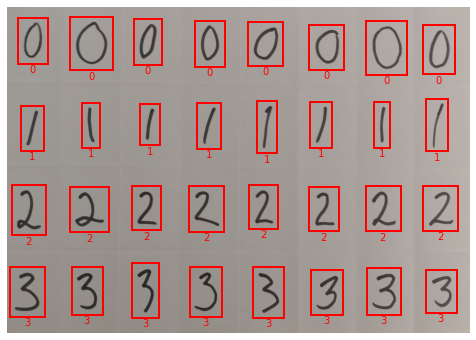

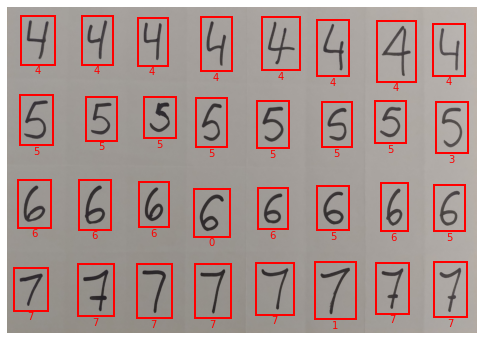

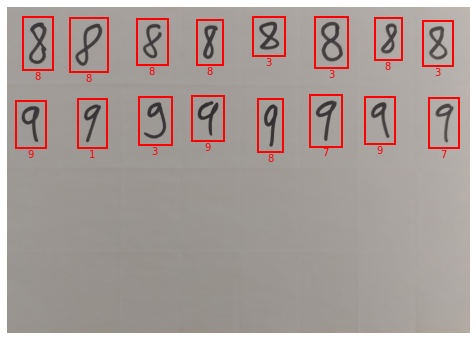

In [10]:
def tunnista_numerot_ja_luokittele(kuva, luokittelija):
    """
    Tämä funktio tunnistaa käsinkirjoitetut numerot kuvasta, laskee niille HOG-piirteet ja luokittelee ne piirteiden perusteella
    """
    plt.figure()
    plt.axis('off')

    # Suodatetaan kuvaa
    harmaasävykuva = rgb2gray(kuva)
    kynnysarvo = threshold_sauvola(harmaasävykuva, window_size=155)
    binarisointi_sauvola = harmaasävykuva > kynnysarvo
    suodatettu_kuva = ndimage.median_filter(binarisointi_sauvola, size=15)

    # Etsitään suorakulmiot
    ääriviivat = measure.find_contours(suodatettu_kuva, 0)
    suorakulmiot = []
    siirros = 25
    for ääriviiva in ääriviivat:
        # xmin, xmax, ymin, ymax
        suorakulmiot.append([int(np.min(ääriviiva[:,0])-siirros), int(np.max(ääriviiva[:,0])+siirros), int(np.min(ääriviiva[:,1])-siirros), int(np.max(ääriviiva[:,1])+siirros)])

    # Poistetaan suorakulmiot, jotka ovat sisäkkäin ja jätetään sisäkkäisistä suorakulmioista ulommaisin
    poistettavat_indeksit = []
    for i in range(len(suorakulmiot)):
        suorakulmio1 = suorakulmiot[i]
        suorakulmio1_ala = (suorakulmio1[1]-suorakulmio1[0])*(suorakulmio1[3]-suorakulmio1[2])
        for j in range(len(suorakulmiot)):
            if i >= j:
                continue
            suorakulmio2 = suorakulmiot[j]
            suorakulmio2_ala = (suorakulmio2[1]-suorakulmio2[0])*(suorakulmio2[3]-suorakulmio2[2])
            if (suorakulmio2[0]>suorakulmio1[0] and suorakulmio2[0]<suorakulmio1[1]) and (suorakulmio2[2]>suorakulmio1[2] and suorakulmio2[2]<suorakulmio1[3]):
                if suorakulmio1_ala >= suorakulmio2_ala:
                    poistettavat_indeksit.append(j)
                else:
                    poistettavat_indeksit.append(i)
    suorakulmiot = [i for j, i in enumerate(suorakulmiot) if j not in poistettavat_indeksit]

    # Segmentoidaan kuva ja lasketaan segmentoiduille alueille HOG-piirteet
    # Lopuksi käytetään luokittelijaa tunnistamaan kuvan käsinkirjoitetut numerot
    plt.imshow(kuva)
    for suorakulmio in suorakulmiot:
        rajattu_alue = harmaasävykuva[suorakulmio[0]:suorakulmio[1],suorakulmio[2]:suorakulmio[3]]
        rajattu_alue = resize(rajattu_alue, (28,28), order=0)
        rajattu_alue = np.asarray(minmax_scale(rajattu_alue.ravel(), feature_range=(0, 255)), dtype=int).reshape((28,28))
        rajattu_alue[rajattu_alue>220] = 255
        hog_piirteet = [hog(rajattu_alue, orientations=9, pixels_per_cell=(7, 7), cells_per_block=(1, 1), block_norm="L2-Hys",visualize=False)]
        ennuste = luokittelija.predict(hog_piirteet)
        plt.text(suorakulmio[2] + (suorakulmio[3]-suorakulmio[2])//2 - 15, suorakulmio[1] + (1.5*siirros), str(int(ennuste)), color='r')
    ax = plt.gca()
    for suorakulmio in suorakulmiot:
        xmin, xmax, ymin, ymax = suorakulmio[0], suorakulmio[1], suorakulmio[2], suorakulmio[3]
        suorakulmio_piirros = mpatches.Rectangle((ymin, xmin), ymax - ymin, xmax - xmin,fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(suorakulmio_piirros)

# Ladataan testikuvat
kuva1 = io.imread('data/kuva1.jpg')
kuva2 = io.imread('data/kuva2.jpg')
kuva3 = io.imread('data/kuva3.jpg')

# Tunnistetaan testikuvista käsinkirjoitetut numerot
tunnista_numerot_ja_luokittele(kuva1, luokittelija_knn_validoitu)
tunnista_numerot_ja_luokittele(kuva2, luokittelija_knn_validoitu)
tunnista_numerot_ja_luokittele(kuva3, luokittelija_knn_validoitu)

Täytä lopuksi sekaannusmatriisi vastaamaan kolmen testikuvan luokittelutulosta.

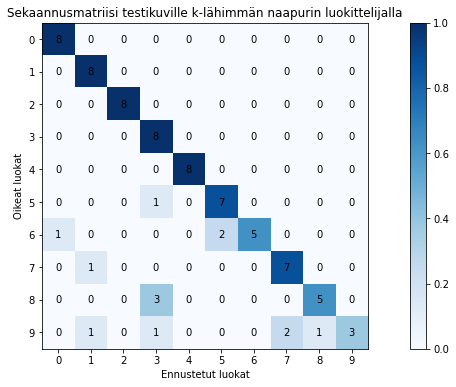

In [11]:
# Täytä sekaannusmatriisi vastaamaan kolmen testikuvan luokittelutulosta
#-------- TÄHÄN SINUN KOODI --------
sekaannusmatriisi = [[8,0,0,0,0,0,0,0,0,0],
                     [0,8,0,0,0,0,0,0,0,0],
                     [0,0,8,0,0,0,0,0,0,0],
                     [0,0,0,8,0,0,0,0,0,0],
                     [0,0,0,0,8,0,0,0,0,0],
                     [0,0,0,1,0,7,0,0,0,0],
                     [1,0,0,0,0,2,5,0,0,0],
                     [0,1,0,0,0,0,0,7,0,0],
                     [0,0,0,3,0,0,0,0,5,0],
                     [0,1,0,1,0,0,0,2,1,3]]
#-----------------------------------

tulosta_sekaannusmatriisi(np.array(sekaannusmatriisi), 'Sekaannusmatriisi testikuville k-lähimmän naapurin luokittelijalla')

# Tehtävä 2. Balansoidun ja epäbalansoidun opetusdatan vaikutus luokittelijan suorituskykyyn

Toisessa tehtävässä vertaillaan balansoidulla ja epäbalansoidulla datalla opetettujen luokittelijoiden suorituskykyjen eroa. Monet tosielämän datat ovat epäbalansoituja, joissa kiinnostavasta ilmiöstä on vähän näytteitä verrattuna datan muihin luokkiin. Mikäli datan epäbalanssin jättää huomioimatta luokittelijaa opetettaessa ja testattaessa, voi sillä olla negatiivisia vaikutuksia luokittelijan suorituskykyyn ja sen suorituskyvystä muodostuu väärä kuva.

Datana käytetään öljyvuotojen havaitsemiseksi merenpinnasta otettuja kuvan 3 kaltaisia satelliittikuvia, jotka ovat muunnettu numeroarvoisiksi piirteiksi. Satelliittikuvien piirteiden irrottaminen on toteutettu digitaalisilla kuvankäsittelytekniikoilla. Muunnetut 49 piirrettä kuvaavat mm. mahdollisen öljyvuotoalueen keskipisteen sijaintia kuvassa, alueen muotoa, pinta-alaa, intensiteettiä ja reunan rosoisuutta.

Yhteensä datassa on 937 näytettä, joista 896 kuuluu luokkaan -1 (ei öljyvuotoa) ja 41 luokkaan 1 (öljyvuoto).  Jaetaan data 80:20 jakosuhteella opetusdataan ja testidataan. Havainnollistetaan opetusdatan ja testidatan epäbalanssia pylväsdiagrammeilla. Luokittelijoina ongelman ratkaisemiseksi käytetään satunnaismetsää, logistista regressiota ja k-lähimmän naapurin luokittelijaa, joiden hyperparametrien arvot on jo etukäteen tiedossa, eikä niitä tarvitse erikseen validoida.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='kuvat\oil_spill.jpg' width='550' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Kuva 3. Satelliittikuva merenpinnasta öljyvuotojen tunnistamiseksi.</span>
</div>
<br>

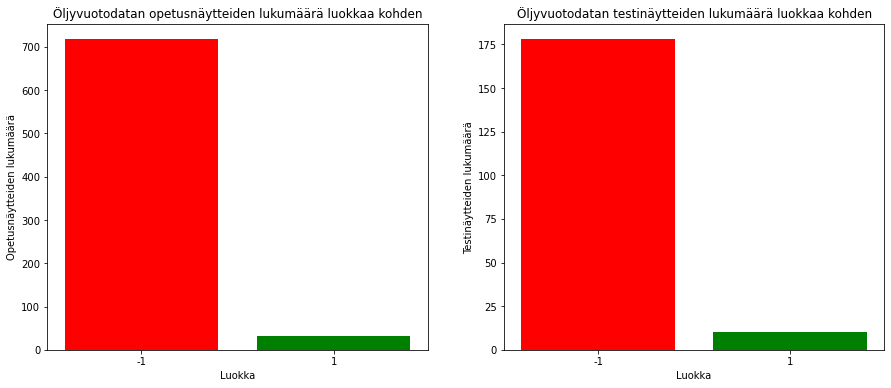

Opetusdatan luokassa -1 on 718 näytettä ja luokassa 1 on 31 näytettä
Testidatan luokassa -1 on 178 näytettä ja luokassa 1 on 10 näytettä


In [12]:
# Ladataan öljyvuotodata. Muuttuja data2 sisältää 49 piirrettä ja muuttuja luokat2 luokkatiedot
data2, luokat2 = datasets.fetch_openml('oil_spill', return_X_y=True)
luokat2 = np.asarray(luokat2, 'int')

# Jaetaan piirteet opetusdataan ja testidataan
data2_opetus, data2_testi, luokat2_opetus, luokat2_testi = train_test_split(data2, luokat2, test_size=(1/5), random_state=0)

# Havainnollistetaan opetusdatan epäbalanssia pylväsdiagrammilla
plt.subplot(121)
kategoriat_opetus, määrät_opetus = np.unique(luokat2_opetus.astype('U'), return_counts=True)
plt.bar(kategoriat_opetus, määrät_opetus, color=['red','green'])
plt.xlabel('Luokka')
plt.ylabel('Opetusnäytteiden lukumäärä')
plt.title('Öljyvuotodatan opetusnäytteiden lukumäärä luokkaa kohden')

# Havainnollistetaan testidatan epäbalanssia pylväsdiagrammilla
plt.subplot(122)
kategoriat_testi, määrät_testi = np.unique(luokat2_testi.astype('U'), return_counts=True)
plt.bar(kategoriat_testi, määrät_testi, color=['red','green'])
plt.xlabel('Luokka')
plt.ylabel('Testinäytteiden lukumäärä')
plt.title('Öljyvuotodatan testinäytteiden lukumäärä luokkaa kohden')
plt.show()

# Tulostetaan opetusdatan ja testidatan näytteiden lukumäärät luokkaa kohden
print('Opetusdatan luokassa {} on {} näytettä ja luokassa {} on {} näytettä'.format(kategoriat_opetus[0], määrät_opetus[0], kategoriat_opetus[1], määrät_opetus[1]))
print('Testidatan luokassa {} on {} näytettä ja luokassa {} on {} näytettä'.format(kategoriat_testi[0], määrät_testi[0], kategoriat_testi[1], määrät_testi[1]))

Datan ollessa vahvasti epäbalanssissa, ei luokittelutarkkuus anna totuudenmukaista kuvaa luokittelijan suorituskyvystä. Usein luokittelijat oppivat tunnistamaan enemmistöluokan näytteet hyvin, mutta kiinnostavien vähemmistöluokan näytteiden tunnistus on heikkoa. Jos esimerkiksi luokittelija tunnistaisi öljyvuotoluokitteluongelman testidatan kaikki näytteet luokkaan -1, saavutettaisiin 94,7 % luokittelutarkkuus, vaikka mitään luokittelua ei todellisuudessa ole tapahtunut. Kyseistä ilmiötä kutsutaan luokittelutarkkuuden paradoksiksi. Tästä syystä epäbalansoidulle datalle käytetään luokittelutarkkuuden sijaan mittoja, kuten sensitiivisyys/saanti/herkkyys ja positiivinen ennustearvo/tarkkuus arvioimaan, kuinka hyvin luokittelija oikeasti suoriutuu luokittelusta.

Arvioidaan opetettujen luokittelijoiden suorituskykyä binäärisen kahden luokan luokitteluongelman testidatan sekaannusmatriiseista. Vertaillaan suorituskyvyn mittoja luokittelutarkkuus, sensitiivisyys, positiivinen ennustearvo ja F1-arvo (engl. F1 score), jotka lasketaan seuraavilla yhtälöillä.

<br><br>
\begin{equation}
\text{Luokittelutarkkuus} = \frac{TP+TN}{P+N} = \frac{TP+TN}{TP+FN+TN+FP}
\end{equation}

<br><br>
\begin{equation}
\text{Sensitiivisyys} = \frac{TP}{P} = \frac{TP}{TP+FN}
\end{equation}

<br><br>
\begin{equation}
\text{Positiivinen ennustearvo} = \frac{TP}{TP+FP}
\end{equation}

<br><br>
\begin{equation}
\text{F1-arvo} = \frac{2 \cdot \text{sensitiivisyys} \cdot \text{positiivinen ennustearvo}}{\text{sensitiivisyys}+\text{positiivinen ennustearvo}}
\end{equation}
<br><br>

F1-arvo on sensitiivisyyden ja positiivisen ennustearvon harmoninen keskiarvo. Toteuta yhtälöiden suorituskyvyn mitat.

Toteutettuasi mitat, tarkasta vielä öljyvuotodatalla opetetulle satunnaismetsälle, että saat valmiita scikit-learn kirjaston funktioita [metrics.accuracy_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), [metrics.recall_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html), [metrics.precision_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) ja [metrics.f1_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) vastaavat arvot.

In [13]:
def laske_luokittelutarkkuus(sekaannusmatriisi):
    """
    Tässä funktiossa lasketaan luokittelutarkkuus (engl. accuracy) 2x2 sekaannusmatriisista
    """
    TN, FP, FN, TP = sekaannusmatriisi.ravel()
    #-------- TÄHÄN SINUN KOODI --------
    # Laske luokittelutarkkuus
    luokittelutarkkuus = (TP+TN)/(TP+FN+TN+FP)
    # Funktio palauttaa luokittelutarkkuuden
    return luokittelutarkkuus
    #-----------------------------------

def laske_sensitiivisyys(sekaannusmatriisi):
    """
    Tässä funktiossa lasketaan sensitiivisyys (engl. recall) 2x2 sekaannusmatriisista
    """
    TN, FP, FN, TP = sekaannusmatriisi.ravel()
    #-------- TÄHÄN SINUN KOODI --------
    # Laske sensitiivisyys
    sensitiivisyys = TP/(TP+FN)
    # Funktio palauttaa sensitiivisyyden
    return sensitiivisyys
    #-----------------------------------
    
def laske_positiivinen_ennustearvo(sekaannusmatriisi):
    """
    Tässä funktiossa lasketaan positiivinen ennustearvo (engl. precision) 2x2 sekaannusmatriisista
    """
    TN, FP, FN, TP = sekaannusmatriisi.ravel()
    #-------- TÄHÄN SINUN KOODI --------
    # Laske positiivinen ennustearvo
    positiivinen_ennustearvo = TP/(TP+FP)
    # Funktio palauttaa positiivisen ennustearvon
    return positiivinen_ennustearvo
    #-----------------------------------
    
def laske_F1_arvo(sensitiivisyys, positiivinen_ennustearvo):
    """
    Tässä funktiossa lasketaan f1-arvo sensitiivisyyden ja positiivisen ennustearvon perusteella
    """
    #-------- TÄHÄN SINUN KOODI --------
    # Laske F1-arvo
    F1_arvo = (2*sensitiivisyys*positiivinen_ennustearvo)/(sensitiivisyys+positiivinen_ennustearvo)
    # Funktio palauttaa F1-arvon
    return F1_arvo
    #-----------------------------------

# Opetetaan satunnaismetsä ja sijoitetaan ennustetut testidatan luokat sekaannusmatriisiin
luokittelija2_satunnaismetsä = RandomForestClassifier(n_estimators=100, random_state=0).fit(data2_opetus, luokat2_opetus)
sekaannusmatriisi2_satunnaismetsä = confusion_matrix(luokat2_testi,luokittelija2_satunnaismetsä.predict(data2_testi))

print('Luokittelutarkkuus satunnaismetsälle scikit-learn kirjaston valmiilla funktiolla: {}'.format(accuracy_score(luokat2_testi, luokittelija2_satunnaismetsä.predict(data2_testi))))
print('Sensitiivisyys satunnaismetsälle scikit-learn kirjaston valmiilla funktiolla: {}'.format(recall_score(luokat2_testi, luokittelija2_satunnaismetsä.predict(data2_testi))))
print('Positiivinen ennustearvo satunnaismetsälle scikit-learn kirjaston valmiilla funktiolla: {}'.format(precision_score(luokat2_testi, luokittelija2_satunnaismetsä.predict(data2_testi))))
print('F1-arvo satunnaismetsälle scikit-learn kirjaston valmiilla funktiolla: {}'.format(f1_score(luokat2_testi, luokittelija2_satunnaismetsä.predict(data2_testi))))

print('\nLuokittelutarkkuus satunnaismetsälle toteuttamallasi funktiolla: {}'.format(laske_luokittelutarkkuus(sekaannusmatriisi2_satunnaismetsä)))
print('Sensitiivisyys satunnaismetsälle toteuttamallasi funktiolla: {}'.format(laske_sensitiivisyys(sekaannusmatriisi2_satunnaismetsä)))
print('Positiivinen ennustearvo satunnaismetsälle toteuttamallasi funktiolla: {}'.format(laske_positiivinen_ennustearvo(sekaannusmatriisi2_satunnaismetsä)))
print('F1-arvo satunnaismetsälle toteuttamallasi funktiolla: {}'.format(laske_F1_arvo(laske_sensitiivisyys(sekaannusmatriisi2_satunnaismetsä), laske_positiivinen_ennustearvo(sekaannusmatriisi2_satunnaismetsä))))

Luokittelutarkkuus satunnaismetsälle scikit-learn kirjaston valmiilla funktiolla: 0.9680851063829787
Sensitiivisyys satunnaismetsälle scikit-learn kirjaston valmiilla funktiolla: 0.5
Positiivinen ennustearvo satunnaismetsälle scikit-learn kirjaston valmiilla funktiolla: 0.8333333333333334
F1-arvo satunnaismetsälle scikit-learn kirjaston valmiilla funktiolla: 0.625

Luokittelutarkkuus satunnaismetsälle toteuttamallasi funktiolla: 0.9680851063829787
Sensitiivisyys satunnaismetsälle toteuttamallasi funktiolla: 0.5
Positiivinen ennustearvo satunnaismetsälle toteuttamallasi funktiolla: 0.8333333333333334
F1-arvo satunnaismetsälle toteuttamallasi funktiolla: 0.625


Opetetaan lisäksi epäbalansoidun öljyvuotodatan opetusnäytteillä logistinen regressio ja k-lähimmän naapurin luokittelija. Piirretään kuvaajaan kaikille kolmelle luokittelijalle ROC-käyrät ja lasketaan niitä vastaavat ROC AUC-arvot.

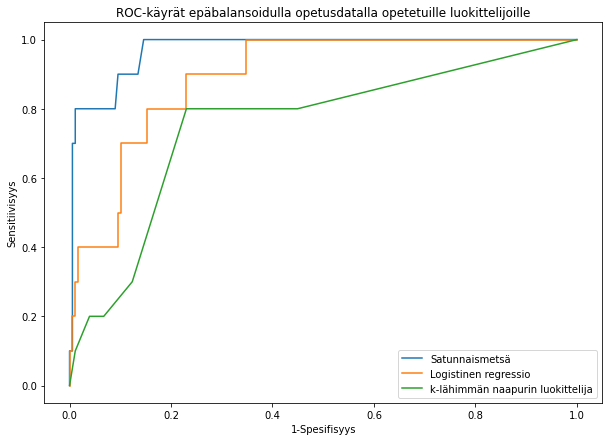

Satunnaismetsän ROC AUC-arvo: 0.972
Logistisen regression ROC AUC-arvo: 0.894
k-lähimmän naapurin luokittelijan ROC AUC-arvo: 0.754


In [14]:
# Opetetaan öljyvuotodatan opetusnäytteillä logistinen regressio ja k-lähimmän naapurin luokittelija
luokittelija2_logistinen_regressio = LogisticRegression(C=50, solver='liblinear', random_state=0).fit(data2_opetus, luokat2_opetus)
luokittelija2_knn = KNeighborsClassifier(n_neighbors=35).fit(data2_opetus, luokat2_opetus)

# Lasketaan testidatan posterioritodennäköisyydet
posterioritodennäköisyydet_satunnaismetsä = luokittelija2_satunnaismetsä.predict_proba(data2_testi)[:, 1]
posterioritodennäköisyydet_logistinen_regressio = luokittelija2_logistinen_regressio.predict_proba(data2_testi)[:, 1]
posterioritodennäköisyydet_knn = luokittelija2_knn.predict_proba(data2_testi)[:, 1]

# Lasketaan ROC-käyrät
fpr_satunnaismetsä, tpr_satunnaismetsä, _ = roc_curve(luokat2_testi, posterioritodennäköisyydet_satunnaismetsä)
fpr_logistinen_regressio, tpr_logistinen_regressio, _ = roc_curve(luokat2_testi, posterioritodennäköisyydet_logistinen_regressio)
fpr_knn, tpr_knn, _ = roc_curve(luokat2_testi, posterioritodennäköisyydet_knn)

# Piirretään kuvaajaan kaikkien kolmen luokittelijan ROC-käyrät
plt.figure(figsize=(10,7))
plt.plot(fpr_satunnaismetsä, tpr_satunnaismetsä, label='Satunnaismetsä')
plt.plot(fpr_logistinen_regressio, tpr_logistinen_regressio, label='Logistinen regressio')
plt.plot(fpr_knn, tpr_knn, label='k-lähimmän naapurin luokittelija')
plt.xlabel('1-Spesifisyys')
plt.ylabel('Sensitiivisyys')
plt.title('ROC-käyrät epäbalansoidulla opetusdatalla opetetuille luokittelijoille')
plt.legend()
plt.show()

# Tulostetaan ROC-käyriä vastaavat ROC AUC-arvot
print('Satunnaismetsän ROC AUC-arvo: {}'.format(round(roc_auc_score(luokat2_testi, posterioritodennäköisyydet_satunnaismetsä),3)))
print('Logistisen regression ROC AUC-arvo: {}'.format(round(roc_auc_score(luokat2_testi, posterioritodennäköisyydet_logistinen_regressio),3)))
print('k-lähimmän naapurin luokittelijan ROC AUC-arvo: {}'.format(round(roc_auc_score(luokat2_testi, posterioritodennäköisyydet_knn),3)))

Piirretään kuvaajaan luokittelijoille positiivinen ennustearvo - sensitiivisyys käyrät ja lasketaan niitä vastaavat PR AUC-arvot.

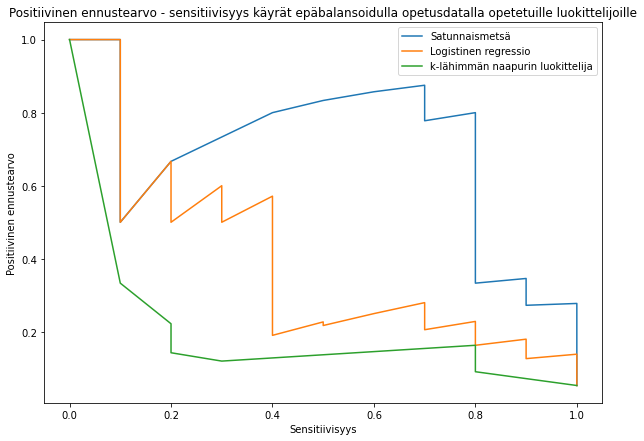

Satunnaismetsän PR AUC-arvo: 0.698
Logistisen regression PR AUC-arvo: 0.39
k-lähimmän naapurin luokittelijan PR AUC-arvo: 0.193


In [15]:
# Lasketaan PR-käyrät
positiiviset_ennustearvot_satunnaismetsä, sensitiivisyydet_satunnaismetsä, _ = precision_recall_curve(luokat2_testi, posterioritodennäköisyydet_satunnaismetsä)
positiiviset_ennustearvot_logistinen_regressio, sensitiivisyydet_logistinen_regressio, _ = precision_recall_curve(luokat2_testi, posterioritodennäköisyydet_logistinen_regressio)
positiiviset_ennustearvot_knn, sensitiivisyydet_knn, _ = precision_recall_curve(luokat2_testi, posterioritodennäköisyydet_knn)

# Piirretään kuvaajaan kaikkien kolmen luokittelijan PR-käyrät
plt.figure(figsize=(10,7))
plt.plot(sensitiivisyydet_satunnaismetsä, positiiviset_ennustearvot_satunnaismetsä, label='Satunnaismetsä')
plt.plot(sensitiivisyydet_logistinen_regressio, positiiviset_ennustearvot_logistinen_regressio, label='Logistinen regressio')
plt.plot(sensitiivisyydet_knn, positiiviset_ennustearvot_knn, label='k-lähimmän naapurin luokittelija')
plt.xlabel('Sensitiivisyys')
plt.ylabel('Positiivinen ennustearvo')
plt.title('Positiivinen ennustearvo - sensitiivisyys käyrät epäbalansoidulla opetusdatalla opetetuille luokittelijoille')
plt.legend()
plt.show()

# Tulostetaan PR-käyriä vastaavat PR AUC-arvot
print('Satunnaismetsän PR AUC-arvo: {}'.format(round(auc(sensitiivisyydet_satunnaismetsä, positiiviset_ennustearvot_satunnaismetsä),3)))
print('Logistisen regression PR AUC-arvo: {}'.format(round(auc(sensitiivisyydet_logistinen_regressio, positiiviset_ennustearvot_logistinen_regressio),3)))
print('k-lähimmän naapurin luokittelijan PR AUC-arvo: {}'.format(round(auc(sensitiivisyydet_knn, positiiviset_ennustearvot_knn),3)))

Lasketaan lopuksi kaikki luokittelijoiden suorituskykyä kuvaavat mitta-arvot ja esitetään ne taulukossa.

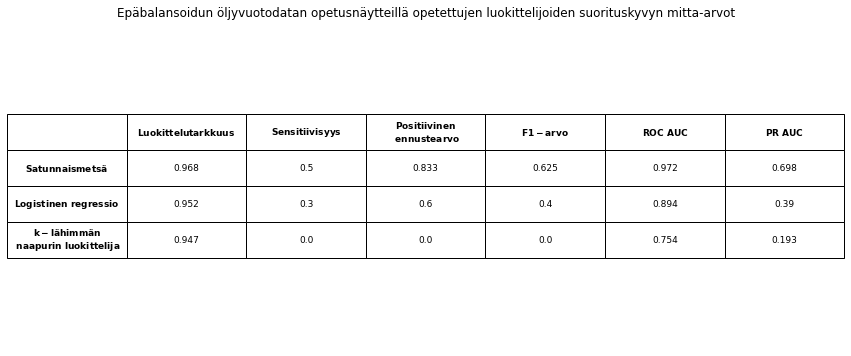

In [16]:
def laske_mitta_arvot(data_testi, luokat_testi, luokittelija, luokittelijan_nimi):
    """
    Tässä funktiossa lasketaan luokittelijan suorituskyvyn mitta-arvot ja tallennetaan ne lopuksi listaan
    """
    # Lasketaan luokittelutarkkuus, sensitiivisyys, positiivinen ennustearo, F1-arvo, ROC AUC-arvo ja PR AUC-arvo
    luokittelutarkkuus = round(accuracy_score(luokat_testi, luokittelija.predict(data_testi)),3)
    sensitiivisyys = round(recall_score(luokat_testi, luokittelija.predict(data_testi)),3)
    positiivinen_ennustearvo = round(precision_score(luokat_testi, luokittelija.predict(data_testi)),3)
    f1_arvo = round(f1_score(luokat_testi, luokittelija.predict(data_testi)),3)
    roc_auc = round(roc_auc_score(luokat_testi, luokittelija.predict_proba(data_testi)[:, 1]),3)    
    positiiviset_ennustearvot, sensitiivisyydet, _ = precision_recall_curve(luokat_testi, luokittelija.predict_proba(data_testi)[:, 1])
    pr_auc = round(auc(sensitiivisyydet, positiiviset_ennustearvot),3)
    return [luokittelijan_nimi, luokittelutarkkuus, sensitiivisyys, positiivinen_ennustearvo, f1_arvo, roc_auc, pr_auc]

# Tehdään taulukko suorituskyvyn mitta-arvojen esittämiseksi
mitta_arvot = []
mitta_arvot.append(['','$\\bf{Luokittelutarkkuus}$','$\\bf{Sensitiivisyys}$','$\\bf{Positiivinen}$\n $\\bf{ennustearvo}$','$\\bf{F1-arvo}$','$\\bf{ROC\\ AUC}$','$\\bf{PR\\ AUC}$'])
mitta_arvot.append(laske_mitta_arvot(data2_testi, luokat2_testi, luokittelija2_satunnaismetsä, '$\\bf{Satunnaismetsä}$'))
mitta_arvot.append(laske_mitta_arvot(data2_testi, luokat2_testi, luokittelija2_logistinen_regressio, '$\\bf{Logistinen\\ regressio}$'))
mitta_arvot.append(laske_mitta_arvot(data2_testi, luokat2_testi, luokittelija2_knn, '$\\bf{k-lähimmän}$\n $\\bf{naapurin\\ luokittelija}$'))

# Tulostetaan taulukko
taulukko = plt.gca().table(cellText=mitta_arvot, loc='center', cellLoc='center')
taulukko.auto_set_font_size(False)
taulukko.set_fontsize(9)
taulukko.scale(1,3)
plt.gca().axis('off')
plt.title('Epäbalansoidun öljyvuotodatan opetusnäytteillä opetettujen luokittelijoiden suorituskyvyn mitta-arvot')
plt.show()

**Luettele luokittelijat paremmuusjärjestyksessä suorituskyvyn mitta-arvojen, ROC-käyrien ja positiivinen ennustearvo - sensitiivisyys käyrien perusteella.**

`1. Satunnaismetsä, 2. Logistinen regressio, 3. k-lähimmän naapurin luokittelija. `

## Opetusdatan ylinäytteistys

Suoritetaan opetusdatalle ylinäytteistys SVMSMOTE-algoritmilla luokittelijoiden suorituskykyn parantamiseksi. Havainnollistetaan ylinäytteistetyn opetusdatan epäbalanssia pylväsdiagrammilla. Pylväsdiagrammista nähdään, että kiinnostavan vähemmistöluokan näytteiden lukumäärä on kasvanut, mutta enemmistöluokan näytteiden lukumäärä on pysynyt samana. Epäbalanssin määrä on vähentynyt merkittävästi.

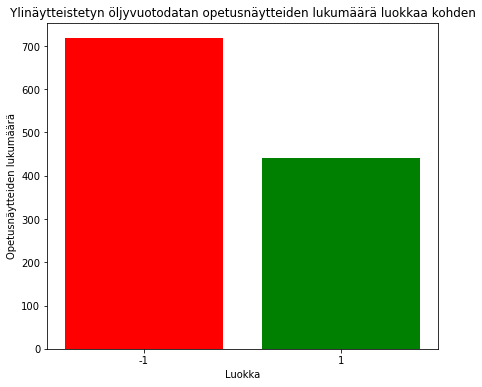

Opetusdatan luokassa -1 on 718 näytettä ja luokassa 1 on 441 näytettä


In [17]:
# Suoritetaan ylinäytteistys SVMSMOTE-algoritmilla
data2_opetus_ylinäytteistetty, luokat2_opetus_ylinäytteistetty = SVMSMOTE(random_state=0).fit_resample(data2_opetus, luokat2_opetus)

# Havainnollistetaan opetusdatan epäbalanssia pylväsdiagrammilla
plt.figure(figsize=(7,6))
kategoriat_opetus_ylinäytteistetty, määrät_opetus_ylinäytteistetty = np.unique(luokat2_opetus_ylinäytteistetty.astype('U'), return_counts=True)
plt.bar(kategoriat_opetus_ylinäytteistetty, määrät_opetus_ylinäytteistetty, color=['red','green'])
plt.xlabel('Luokka')
plt.ylabel('Opetusnäytteiden lukumäärä')
plt.title('Ylinäytteistetyn öljyvuotodatan opetusnäytteiden lukumäärä luokkaa kohden')
plt.show()

# Tulostetaan opetusdatan näytteiden lukumäärät luokkaa kohden
print('Opetusdatan luokassa {} on {} näytettä ja luokassa {} on {} näytettä'.format(kategoriat_opetus_ylinäytteistetty[0], määrät_opetus_ylinäytteistetty[0], kategoriat_opetus_ylinäytteistetty[1], määrät_opetus_ylinäytteistetty[1]))

Opetetaan ylinäytteistetyllä öljyvuotodatan opetusnäytteillä satunnaismetsä, logistinen regressio ja k-lähimmän naapurin luokittelija. Piirretään kuvaajaan kaikille kolmelle luokittelijalle ROC-käyrät ja lasketaan niitä vastaavat ROC AUC-arvot.

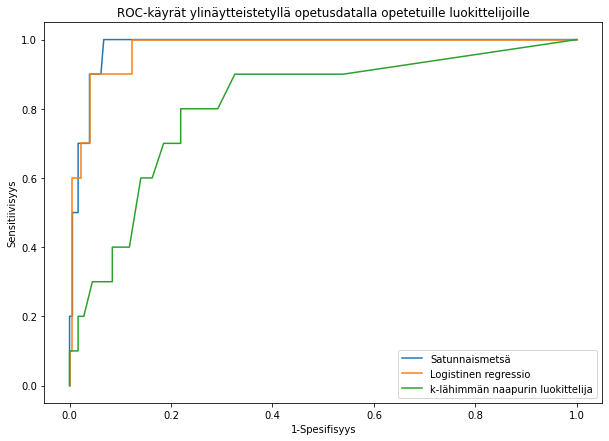

Satunnaismetsän ROC AUC-arvo: 0.981
Logistisen regression ROC AUC-arvo: 0.975
k-lähimmän naapurin luokittelijan ROC AUC-arvo: 0.813


In [18]:
# Opetetaan ylinäytteistetyllä öljyvuotodatan opetusnäytteillä satunnaismetsä, logistinen regressio ja k-lähimmän naapurin luokittelija
luokittelija2_satunnaismetsä_ylinäytteistetty = RandomForestClassifier(n_estimators=100, random_state=0).fit(data2_opetus_ylinäytteistetty, luokat2_opetus_ylinäytteistetty)
luokittelija2_logistinen_regressio_ylinäytteistetty = LogisticRegression(C=50, solver='liblinear', random_state=0).fit(data2_opetus_ylinäytteistetty, luokat2_opetus_ylinäytteistetty)
luokittelija2_knn_ylinäytteistetty = KNeighborsClassifier(n_neighbors=35).fit(data2_opetus_ylinäytteistetty, luokat2_opetus_ylinäytteistetty)

# Lasketaan testidatan posterioritodennäköisyydet
posterioritodennäköisyydet_satunnaismetsä_ylinäytteistetty = luokittelija2_satunnaismetsä_ylinäytteistetty.predict_proba(data2_testi)[:, 1]
posterioritodennäköisyydet_logistinen_regressio_ylinäytteistetty = luokittelija2_logistinen_regressio_ylinäytteistetty.predict_proba(data2_testi)[:, 1]
posterioritodennäköisyydet_knn_ylinäytteistetty = luokittelija2_knn_ylinäytteistetty.predict_proba(data2_testi)[:, 1]

# Lasketaan ROC-käyrät
fpr_satunnaismetsä_ylinäytteistetty, tpr_satunnaismetsä_ylinäytteistetty, _ = roc_curve(luokat2_testi, posterioritodennäköisyydet_satunnaismetsä_ylinäytteistetty)
fpr_logistinen_regressio_ylinäytteistetty, tpr_logistinen_regressio_ylinäytteistetty, _ = roc_curve(luokat2_testi, posterioritodennäköisyydet_logistinen_regressio_ylinäytteistetty)
fpr_knn_ylinäytteistetty, tpr_knn_ylinäytteistetty, _ = roc_curve(luokat2_testi, posterioritodennäköisyydet_knn_ylinäytteistetty)

# Piirretään kuvaajaan kaikkien kolmen luokittelijan ROC-käyrät
plt.figure(figsize=(10,7))
plt.plot(fpr_satunnaismetsä_ylinäytteistetty, tpr_satunnaismetsä_ylinäytteistetty, label='Satunnaismetsä')
plt.plot(fpr_logistinen_regressio_ylinäytteistetty, tpr_logistinen_regressio_ylinäytteistetty, label='Logistinen regressio')
plt.plot(fpr_knn_ylinäytteistetty, tpr_knn_ylinäytteistetty, label='k-lähimmän naapurin luokittelija')
plt.xlabel('1-Spesifisyys')
plt.ylabel('Sensitiivisyys')
plt.title('ROC-käyrät ylinäytteistetyllä opetusdatalla opetetuille luokittelijoille')
plt.legend()
plt.show()

# Tulostetaan ROC-käyriä vastaavat ROC AUC-arvot
print('Satunnaismetsän ROC AUC-arvo: {}'.format(round(roc_auc_score(luokat2_testi, posterioritodennäköisyydet_satunnaismetsä_ylinäytteistetty),3)))
print('Logistisen regression ROC AUC-arvo: {}'.format(round(roc_auc_score(luokat2_testi, posterioritodennäköisyydet_logistinen_regressio_ylinäytteistetty),3)))
print('k-lähimmän naapurin luokittelijan ROC AUC-arvo: {}'.format(round(roc_auc_score(luokat2_testi, posterioritodennäköisyydet_knn_ylinäytteistetty),3)))

Piirretään kuvaajaan luokittelijoille positiivinen ennustearvo - sensitiivisyys käyrät ja lasketaan niitä vastaavat PR AUC-arvot.

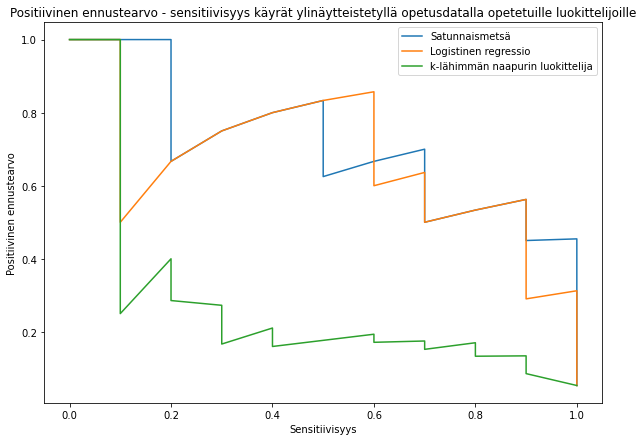

Satunnaismetsän PR AUC-arvo: 0.715
Logistisen regression PR AUC-arvo: 0.671
k-lähimmän naapurin luokittelijan PR AUC-arvo: 0.268


In [19]:
# Lasketaan PR-käyrät
positiiviset_ennustearvot_satunnaismetsä_ylinäytteistetty, sensitiivisyydet_satunnaismetsä_ylinäytteistetty, _ = precision_recall_curve(luokat2_testi, posterioritodennäköisyydet_satunnaismetsä_ylinäytteistetty)
positiiviset_ennustearvot_logistinen_regressio_ylinäytteistetty, sensitiivisyydet_logistinen_regressio_ylinäytteistetty, _ = precision_recall_curve(luokat2_testi, posterioritodennäköisyydet_logistinen_regressio_ylinäytteistetty)
positiiviset_ennustearvot_knn_ylinäytteistetty, sensitiivisyydet_knn_ylinäytteistetty, _ = precision_recall_curve(luokat2_testi, posterioritodennäköisyydet_knn_ylinäytteistetty)

# Piirretään kuvaajaan kaikkien kolmen luokittelijan PR-käyrät
plt.figure(figsize=(10,7))
plt.plot(sensitiivisyydet_satunnaismetsä_ylinäytteistetty, positiiviset_ennustearvot_satunnaismetsä_ylinäytteistetty, label='Satunnaismetsä')
plt.plot(sensitiivisyydet_logistinen_regressio_ylinäytteistetty, positiiviset_ennustearvot_logistinen_regressio_ylinäytteistetty, label='Logistinen regressio')
plt.plot(sensitiivisyydet_knn_ylinäytteistetty, positiiviset_ennustearvot_knn_ylinäytteistetty, label='k-lähimmän naapurin luokittelija')
plt.xlabel('Sensitiivisyys')
plt.ylabel('Positiivinen ennustearvo')
plt.title('Positiivinen ennustearvo - sensitiivisyys käyrät ylinäytteistetyllä opetusdatalla opetetuille luokittelijoille')
plt.legend()
plt.show()

# Tulostetaan PR-käyriä vastaavat PR AUC-arvot
print('Satunnaismetsän PR AUC-arvo: {}'.format(round(auc(sensitiivisyydet_satunnaismetsä_ylinäytteistetty, positiiviset_ennustearvot_satunnaismetsä_ylinäytteistetty),3)))
print('Logistisen regression PR AUC-arvo: {}'.format(round(auc(sensitiivisyydet_logistinen_regressio_ylinäytteistetty, positiiviset_ennustearvot_logistinen_regressio_ylinäytteistetty),3)))
print('k-lähimmän naapurin luokittelijan PR AUC-arvo: {}'.format(round(auc(sensitiivisyydet_knn_ylinäytteistetty, positiiviset_ennustearvot_knn_ylinäytteistetty),3)))

Lasketaan lopuksi kaikki luokittelijoiden suorituskykyä kuvaavat mitta-arvot ja esitetään ne taulukossa.

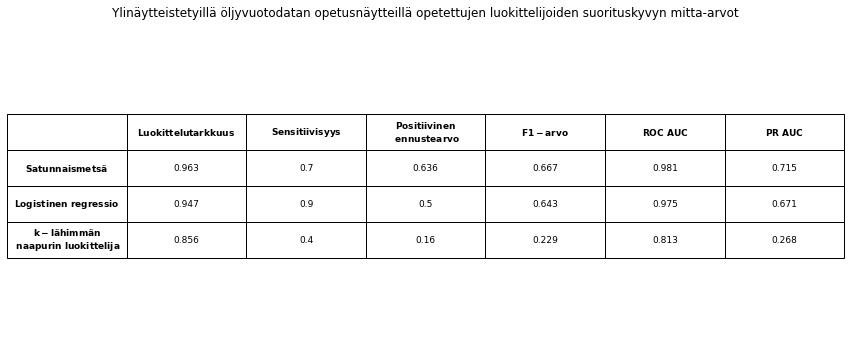

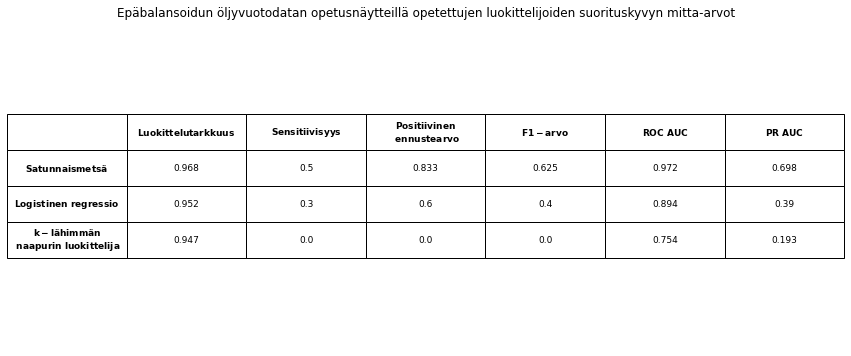

In [20]:
# Tehdään taulukko suorituskyvyn mitta-arvojen esittämiseksi
mitta_arvot_ylinäytteistetty = []
mitta_arvot_ylinäytteistetty.append(['','$\\bf{Luokittelutarkkuus}$','$\\bf{Sensitiivisyys}$','$\\bf{Positiivinen}$\n $\\bf{ennustearvo}$','$\\bf{F1-arvo}$','$\\bf{ROC\\ AUC}$','$\\bf{PR\\ AUC}$'])
mitta_arvot_ylinäytteistetty.append(laske_mitta_arvot(data2_testi, luokat2_testi, luokittelija2_satunnaismetsä_ylinäytteistetty, '$\\bf{Satunnaismetsä}$'))
mitta_arvot_ylinäytteistetty.append(laske_mitta_arvot(data2_testi, luokat2_testi, luokittelija2_logistinen_regressio_ylinäytteistetty, '$\\bf{Logistinen\\ regressio}$'))
mitta_arvot_ylinäytteistetty.append(laske_mitta_arvot(data2_testi, luokat2_testi, luokittelija2_knn_ylinäytteistetty, '$\\bf{k-lähimmän}$\n $\\bf{naapurin\\ luokittelija}$'))

# Tulostetaan vertailun vuoksi molemmat taulukot alekkain
taulukko_ylinäytteistetty = plt.gca().table(cellText=mitta_arvot_ylinäytteistetty, loc='center', cellLoc='center')
taulukko_ylinäytteistetty.auto_set_font_size(False)
taulukko_ylinäytteistetty.set_fontsize(9)
taulukko_ylinäytteistetty.scale(1,3)
plt.gca().axis('off')
plt.title('Ylinäytteistetyillä öljyvuotodatan opetusnäytteillä opetettujen luokittelijoiden suorituskyvyn mitta-arvot')

plt.figure()
taulukko = plt.gca().table(cellText=mitta_arvot, loc='center', cellLoc='center')
taulukko.auto_set_font_size(False)
taulukko.set_fontsize(9)
taulukko.scale(1,3)
plt.gca().axis('off')
plt.title('Epäbalansoidun öljyvuotodatan opetusnäytteillä opetettujen luokittelijoiden suorituskyvyn mitta-arvot')
plt.show()

**Vertaile alkuperäisellä opetusdatalla opetetun ja ylinäytteistetyllä opetusdatalla opetetun k-lähimmän naapurin luokittelijan mitta-arvoja, ROC-käyriä ja positiivinen ennustearvo-sensitiivisyys käyriä. Paraniko luokittelijan suorituskyky, kun erityisesti vähemmistöluokan näytteitä halutaan tunnistaa oikein?**

`Luokittelijan suorituskyky parani, kun erityisesti vähemmistöluokan näytteitä halutaan tunnistaa oikein. Luokittelutarkkuutta lukuunottamatta, suorituskyvyn mitat ovat paremmat ylinäytteistetyllä opetusdatalla.`

# Palaute
Lopuksi vastaa seuraaviin kysymyksiin:

**Kuinka paljon aikaa käytit harjoituksen tekemiseen?**

`Noin 4h.`

**Kohtasitko ongelmia tai haasteita harjoitusta tehdessäsi? Oliko notebookissa riittävän kattava ohjeistus harjoituksen tekemiseen?**

`Ei ongelmia.`

**Muuta palautetta harjoitukseen liittyen?**

`-`

# Palautus

1. Ennen kuin palautat tämän notebookin, **tarkista, että notebookin koodi toimii** ja tuottaa kaikki pyydetyt tulokset valitsemalla valikosta `Kernel -> Restart & Run All`! Huomaa, että tuloksien ajaminen kestää hetken aikaa. Tarkista lisäksi, että olet vastannut kaikkiin lihavoituihin **kysymyksiin.**
2. **Aiempien harjoituksien** palautusohjeisiin poiketen, **älä tyhjennä tulosteita ja muuttujia**, vaan paina tallenna painiketta suoritettuasi 1. vaihe!
3. Nimeä uudelleen tämä notebook-tiedosto muodossa **`JT_H1_[opiskelijanumero(t)].ipynb`** (esim. `JT_H1_1234567.ipynb` jos teet harjoituksen yksin tai `JT_H1_1234567_2345678_3456789.ipynb` jos teette harjoituksen ryhmässä)
4. Palauta **ainoastaan** ratkaisemasi notebook-tiedosto (`.ipynb` päätteinen tiedosto) Moodleen ohjelmointi harjoitus 2 . **Älä siis sisällytä työkansiota tai muita tiedostoja** palautukseesi! **HOX jokainen palauttaa tiedoston itsenäisesti moodleen**
5. Vastaa **Moodlessa ohjelmointiharjoitus 2** vastaaviin kysymyksiin henkilökohtaisesti